In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os.path
import sys
import numpy as np


In [24]:
# Define set of all parameters and meta-parameters
    parameters = {    
    "delta_schooling":[0.5],
        "xi":[0, 30 * 37199.03],
#         , 140 * 37199.03],
        "icus":[3000],
        "tests":[0],
        "frequencies":[(7,14)],
        "eta":[0,0.1]
    }
    
    meta_parameters = {
        "trust_region_radius":[0,0.05,0.1,0.2,0.4,0.6],
        "max_inner_iterations_mult":[1, 1.5, 2],
        "initial_uhat":["dynamic_gradient", "full_lockdown", "full_open"]
    }
    
    n_days = 90
    groups = "all"


In [25]:
# Add all data into one big pandas dataframe

ls = []

for delta in parameters["delta_schooling"]:
    for xi in parameters["xi"]:
        for icus in parameters["icus"]:
            for tests in parameters["tests"]:
                for freq in parameters["frequencies"]:
                    for eta in parameters["eta"]:
                        for initial_uhat in meta_parameters["initial_uhat"]:
                            with open(f"testing_outputs_ndays={n_days}_eta={eta}_tests={tests}_xi={xi*10}_freq={freq[1]}_groups={groups}_initial_uhat={initial_uhat}_opt_bouncing=False.csv", "r") as file:
                                df = pd.read_csv(file, header=None, names=["radius", "factor", "num_iterations", "reward", "time"])
                            if len(df) == 0:
                                print(file.name)
                            df["delta"] = delta
                            df["xi"] = xi
                            df["icus"] = icus
                            df["tests"] = tests
                            df["freq"] = freq[1]
                            df["eta"] = eta
                            df["initial_uhat"] = initial_uhat
                            ls.append(df)

all_data = pd.concat(ls, ignore_index=True)


In [26]:
# First, look for each combination of parameters what combination of meta-param achieves the best rewards

for delta in parameters["delta_schooling"]:
    for xi in parameters["xi"]:
        for icus in parameters["icus"]:
            for tests in parameters["tests"]:
                for freq in parameters["frequencies"]:
                    for eta in parameters["eta"]:
                        maximum_reward = all_data[(all_data.delta == delta) 
                                                 & (all_data.xi == xi) 
                                                 & (all_data.icus == icus)
                                                 & (all_data.tests == tests) 
                                                 & (all_data.freq == freq[1])
                                                 & (all_data.eta == eta)].reward.max()
                        print(f"For xi={xi} and eta={eta}, the maximum reward is: {maximum_reward}")
                        print(f"And these are the meta-parameters that achieve it:")
                        print("Observe that radius == 0 implies that the solution follows the initial uhat")
                        print(all_data[all_data.reward == maximum_reward])
                        print("")

For xi=0 and eta=0, the maximum reward is: 55655867.97208577
And these are the meta-parameters that achieve it:
Observe that radius == 0 implies that the solution follows the initial uhat
    radius  factor  num_iterations        reward         time  delta   xi  \
3     0.05     1.0       20.000000  5.565587e+07  1385.065299    0.5  0.0   
4     0.05     1.5       30.000000  5.565587e+07  1395.110099    0.5  0.0   
5     0.05     2.0       40.000000  5.565587e+07  1408.321419    0.5  0.0   
6     0.10     1.0       10.000000  5.565587e+07  1170.008036    0.5  0.0   
7     0.10     2.0       20.000000  5.565587e+07  1187.123408    0.5  0.0   
8     0.10     1.5       15.000000  5.565587e+07  1190.768425    0.5  0.0   
9     0.20     1.0        5.000000  5.565587e+07  1060.251859    0.5  0.0   
10    0.20     2.0       10.000000  5.565587e+07  1089.156359    0.5  0.0   
11    0.20     1.5        7.500000  5.565587e+07  1089.570733    0.5  0.0   
12    0.60     1.0        1.666667  5.5655

Notice above that for any combination of parameters we achieve the maximum reward for some combination of meta_param

In [29]:
# Now we'll define the ratio of the rewards wrt to the maximum reward 

for delta in parameters["delta_schooling"]:
    for xi in parameters["xi"]:
        for icus in parameters["icus"]:
            for tests in parameters["tests"]:
                for freq in parameters["frequencies"]:
                    for eta in parameters["eta"]:
                        maximum_reward = all_data[(all_data.delta == delta) 
                                                 & (all_data.xi == xi) 
                                                 & (all_data.icus == icus)
                                                 & (all_data.tests == tests) 
                                                 & (all_data.freq == freq[1])
                                                 & (all_data.eta == eta)].reward.max()
                        
                        all_data.loc[(all_data.delta == delta)
                                                 & (all_data.xi == xi) 
                                                 & (all_data.icus == icus)
                                                 & (all_data.tests == tests) 
                                                 & (all_data.freq == freq[1])
                                                 & (all_data.eta == eta), "FractionalReward"] = all_data[(all_data.delta == delta) 
                                                 & (all_data.xi == xi) 
                                                 & (all_data.icus == icus)
                                                 & (all_data.tests == tests) 
                                                 & (all_data.freq == freq[1])
                                                 & (all_data.eta == eta)].reward / maximum_reward


Meta Param: radius = 0, factor = 1, num iterations = 0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9981907197328388, 0.9857012157356176, 0.9783363639320397, 0.9832818100753881]
Average Fractional Reward: 0.986377527368971
Histogram of Fractional Rewards:


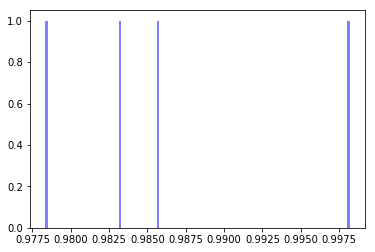

Meta Param: radius = 0, factor = 1, num iterations = 0, initia uhat = full_lockdown
List of Fractional Rewards: [0.2826785395545013, 0.3035397390886124, 0.2116099177273288, 0.2313224269804493]
Average Fractional Reward: 0.25728765583772295
Histogram of Fractional Rewards:


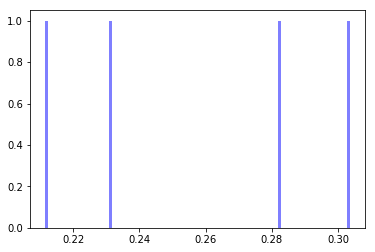

Meta Param: radius = 0, factor = 1, num iterations = 0, initia uhat = full_open
List of Fractional Rewards: [0.8801941581520245, 0.9451510027391891, -1.2884850747719578, -1.408513824991871]
Average Fractional Reward: -0.21791343471815378
Histogram of Fractional Rewards:


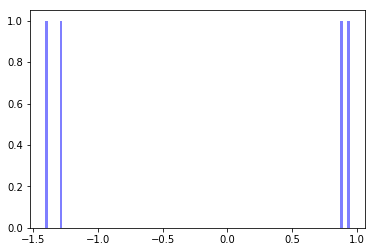

Meta Param: radius = 0, factor = 1.5, num iterations = 0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9981907197328388, 0.9857012157356176, 0.9783363639320397, 0.9832818100753881]
Average Fractional Reward: 0.986377527368971
Histogram of Fractional Rewards:


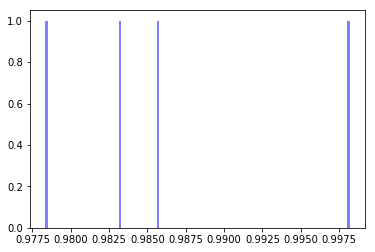

Meta Param: radius = 0, factor = 1.5, num iterations = 0, initia uhat = full_lockdown
List of Fractional Rewards: [0.2826785395545013, 0.3035397390886124, 0.2116099177273288, 0.2313224269804493]
Average Fractional Reward: 0.25728765583772295
Histogram of Fractional Rewards:


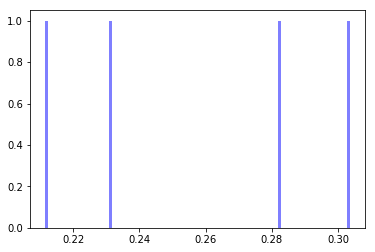

Meta Param: radius = 0, factor = 1.5, num iterations = 0, initia uhat = full_open
List of Fractional Rewards: [0.8801941581520245, 0.9451510027391891, -1.2884850747719578, -1.408513824991871]
Average Fractional Reward: -0.21791343471815378
Histogram of Fractional Rewards:


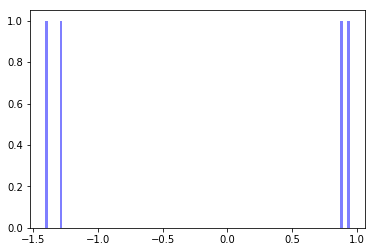

Meta Param: radius = 0, factor = 2, num iterations = 0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9981907197328388, 0.9857012157356176, 0.9783363639320397, 0.9832818100753881]
Average Fractional Reward: 0.986377527368971
Histogram of Fractional Rewards:


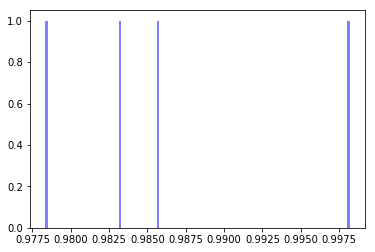

Meta Param: radius = 0, factor = 2, num iterations = 0, initia uhat = full_lockdown
List of Fractional Rewards: [0.2826785395545013, 0.3035397390886124, 0.2116099177273288, 0.2313224269804493]
Average Fractional Reward: 0.25728765583772295
Histogram of Fractional Rewards:


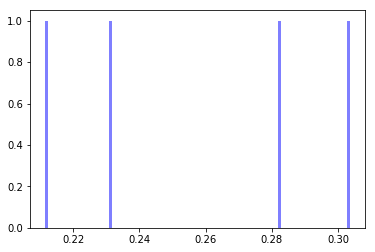

Meta Param: radius = 0, factor = 2, num iterations = 0, initia uhat = full_open
List of Fractional Rewards: [0.8801941581520245, 0.9451510027391891, -1.2884850747719578, -1.408513824991871]
Average Fractional Reward: -0.21791343471815378
Histogram of Fractional Rewards:


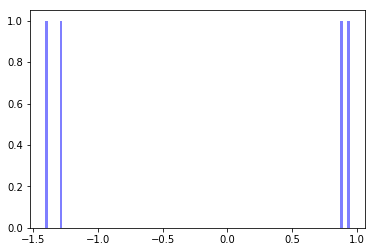

Meta Param: radius = 0.05, factor = 1, num iterations = 20.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9984350234976476, 1.0, 0.9929823745367609]
Average Fractional Reward: 0.9978543495086021
Histogram of Fractional Rewards:


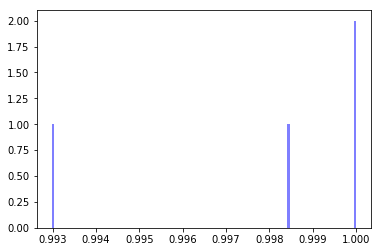

Meta Param: radius = 0.05, factor = 1, num iterations = 20.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9942895984104405, 0.9974284777079644, 0.9952187456390688]
Average Fractional Reward: 0.9967342054393684
Histogram of Fractional Rewards:


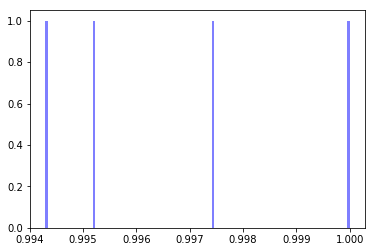

Meta Param: radius = 0.05, factor = 1, num iterations = 20.0, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9939785002172036, 0.9955265368842647, 0.9971550022026914]
Average Fractional Reward: 0.9966650098260399
Histogram of Fractional Rewards:


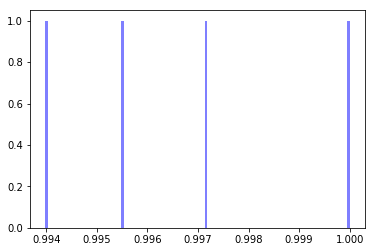

Meta Param: radius = 0.05, factor = 1.5, num iterations = 30.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9969550027796822, 1.0, 0.9929823745367609]
Average Fractional Reward: 0.9974843443291107
Histogram of Fractional Rewards:


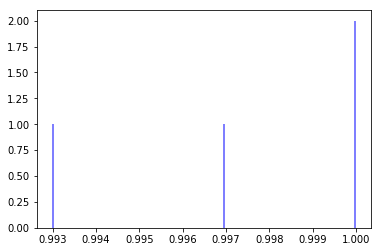

Meta Param: radius = 0.05, factor = 1.5, num iterations = 30.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9933130828400641, 0.9974390775637237, 0.9951445466349951]
Average Fractional Reward: 0.9964741767596959
Histogram of Fractional Rewards:


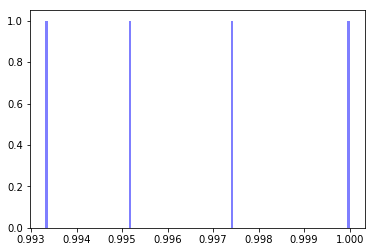

Meta Param: radius = 0.05, factor = 1.5, num iterations = 30.0, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9946413852020697, 0.9973775971328598, 0.998670348517785]
Average Fractional Reward: 0.9976723327131787
Histogram of Fractional Rewards:


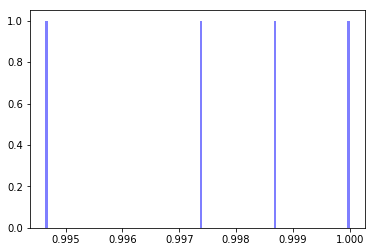

Meta Param: radius = 0.05, factor = 2, num iterations = 40.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9969550027796822, 1.0, 0.9929823745367609]
Average Fractional Reward: 0.9974843443291107
Histogram of Fractional Rewards:


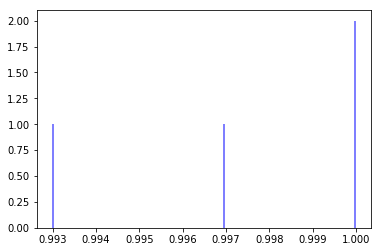

Meta Param: radius = 0.05, factor = 2, num iterations = 40.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9943850513199297, 0.9974390775637237, 0.9951445466349951]
Average Fractional Reward: 0.996742168879662
Histogram of Fractional Rewards:


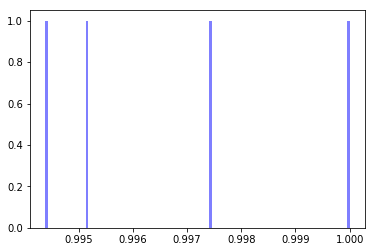

Meta Param: radius = 0.05, factor = 2, num iterations = 40.0, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9946413852020697, 0.9973775971328598, 0.9987880304470619]
Average Fractional Reward: 0.9977017531954979
Histogram of Fractional Rewards:


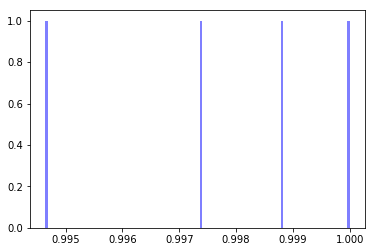

Meta Param: radius = 0.1, factor = 1, num iterations = 10.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9990871921809482, 0.997611222239023, 0.9966518849611843]
Average Fractional Reward: 0.998337574845289
Histogram of Fractional Rewards:


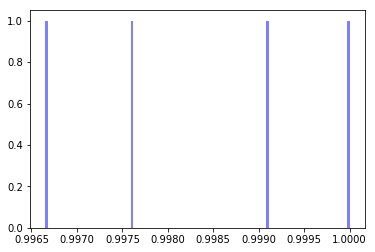

Meta Param: radius = 0.1, factor = 1, num iterations = 10.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9944678428088161, 0.9973231840878168, 0.9925725991909863]
Average Fractional Reward: 0.9960909065219048
Histogram of Fractional Rewards:


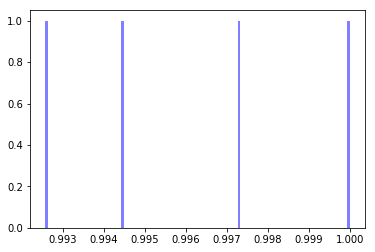

Meta Param: radius = 0.1, factor = 1, num iterations = 10.0, initia uhat = full_open
List of Fractional Rewards: [0.9999999544891683, 0.9940512623558392, 0.9932469118611919, 0.9981792740541313]
Average Fractional Reward: 0.9963693506900827
Histogram of Fractional Rewards:


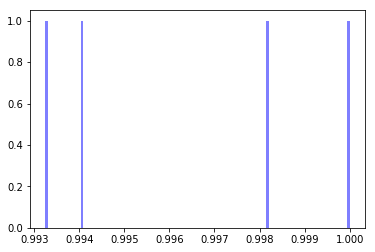

Meta Param: radius = 0.1, factor = 1.5, num iterations = 15.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9977320037275851, 0.997611222239023, 0.9976120359552035]
Average Fractional Reward: 0.9982388154804529
Histogram of Fractional Rewards:


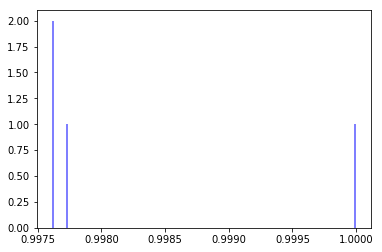

Meta Param: radius = 0.1, factor = 1.5, num iterations = 15.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.991796791999693, 0.9974215337955977, 0.986010961259525]
Average Fractional Reward: 0.9938073217637039
Histogram of Fractional Rewards:


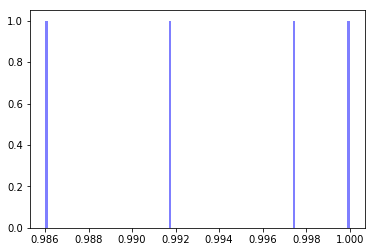

Meta Param: radius = 0.1, factor = 1.5, num iterations = 15.0, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9940512623558392, 0.9973157486235952, 0.9946263103651212]
Average Fractional Reward: 0.9964983303361388
Histogram of Fractional Rewards:


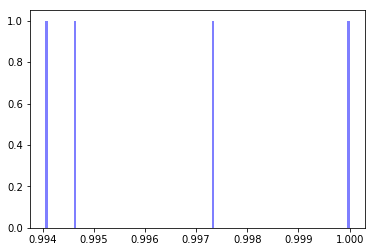

Meta Param: radius = 0.1, factor = 2, num iterations = 20.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9977320037275851, 0.997611222239023, 0.9976120359552035]
Average Fractional Reward: 0.9982388154804529
Histogram of Fractional Rewards:


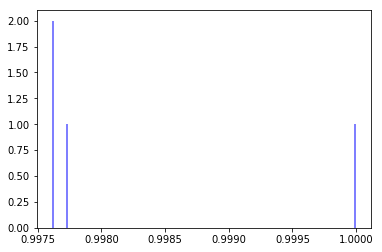

Meta Param: radius = 0.1, factor = 2, num iterations = 20.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.991796791999693, 0.9974215337955977, 0.986010961259525]
Average Fractional Reward: 0.9938073217637039
Histogram of Fractional Rewards:


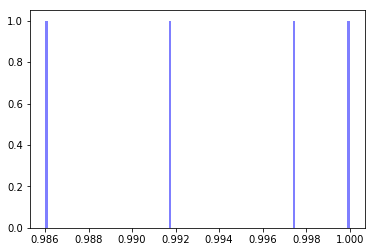

Meta Param: radius = 0.1, factor = 2, num iterations = 20.0, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9944306151286467, 0.9973157486235952, 0.9949072273034624]
Average Fractional Reward: 0.996663397763926
Histogram of Fractional Rewards:


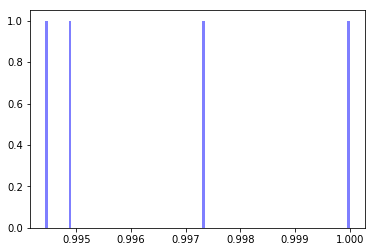

Meta Param: radius = 0.2, factor = 1, num iterations = 5.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9990554689281617, 0.9972398815397302, 0.9999750166017009]
Average Fractional Reward: 0.9990675917673982
Histogram of Fractional Rewards:


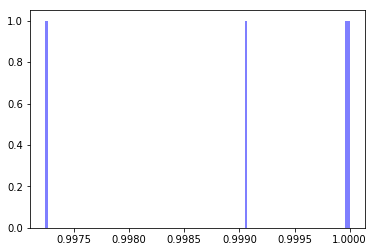

Meta Param: radius = 0.2, factor = 1, num iterations = 5.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9941162965607889, 0.9620669664457817]
Average Fractional Reward: 0.9853944210021902
Histogram of Fractional Rewards:


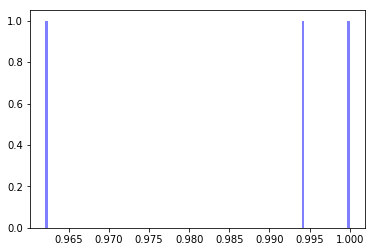

Meta Param: radius = 0.2, factor = 1, num iterations = 5.0, initia uhat = full_open
List of Fractional Rewards: [0.9999999633581418, 0.9941850423706358, 0.9938627615099269, 0.9947486472969405]
Average Fractional Reward: 0.9956991036339112
Histogram of Fractional Rewards:


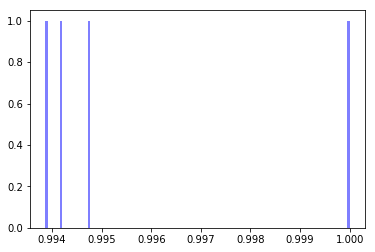

Meta Param: radius = 0.2, factor = 1.5, num iterations = 7.5, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9990554689281617, 0.997495047980877, 1.0]
Average Fractional Reward: 0.9991376292272597
Histogram of Fractional Rewards:


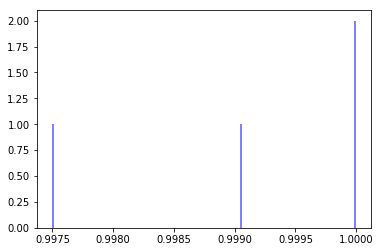

Meta Param: radius = 0.2, factor = 1.5, num iterations = 7.5, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9973465129238355, 0.9974782449102528]
Average Fractional Reward: 0.9982749192780295
Histogram of Fractional Rewards:


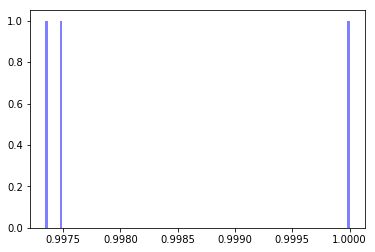

Meta Param: radius = 0.2, factor = 1.5, num iterations = 7.5, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.994858210025326, 0.9782915495002924]
Average Fractional Reward: 0.9910499198418729
Histogram of Fractional Rewards:


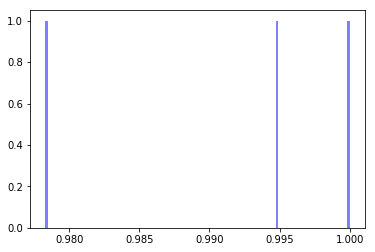

Meta Param: radius = 0.2, factor = 2, num iterations = 10.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.999055214227181, 0.997495047980877, 1.0]
Average Fractional Reward: 0.9991375655520145
Histogram of Fractional Rewards:


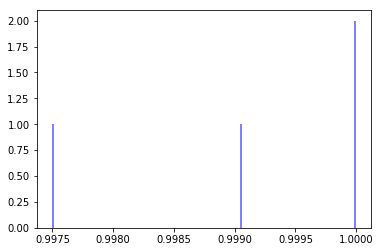

Meta Param: radius = 0.2, factor = 2, num iterations = 10.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9976023814389119, 0.9974782449102528]
Average Fractional Reward: 0.9983602087830549
Histogram of Fractional Rewards:


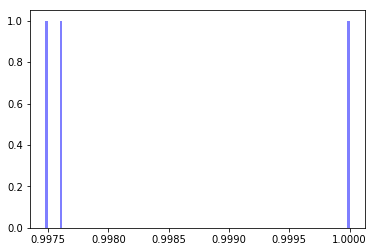

Meta Param: radius = 0.2, factor = 2, num iterations = 10.0, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.997039890289183, 0.9782915495002924]
Average Fractional Reward: 0.9917771465964919
Histogram of Fractional Rewards:


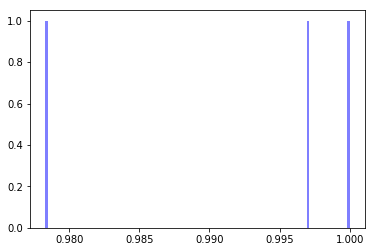

Meta Param: radius = 0.4, factor = 1, num iterations = 2.5, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.99796158300631, 0.9960717654532371, 0.9973621407028117]
Average Fractional Reward: 0.9978488722905896
Histogram of Fractional Rewards:


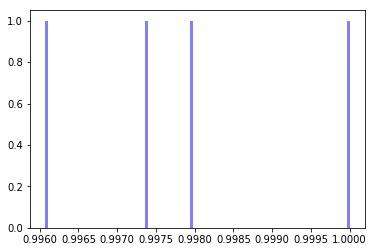

Meta Param: radius = 0.4, factor = 1, num iterations = 2.5, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9960712158561258, 0.992382416737227, 0.9970635317134263]
Average Fractional Reward: 0.9963792910766948
Histogram of Fractional Rewards:


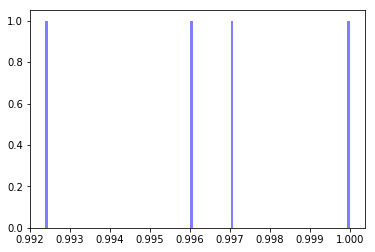

Meta Param: radius = 0.4, factor = 1, num iterations = 2.5, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9959828219336314, 0.9925320815898674, 0.9978280064252595]
Average Fractional Reward: 0.9965857274871897
Histogram of Fractional Rewards:


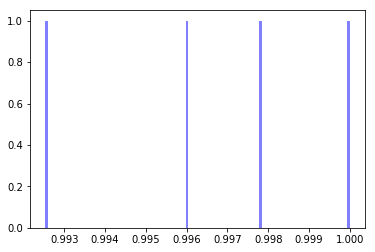

Meta Param: radius = 0.4, factor = 1.5, num iterations = 3.75, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9997799413507129, 0.9963447071697877, 0.9973621407028117]
Average Fractional Reward: 0.9983716973058281
Histogram of Fractional Rewards:


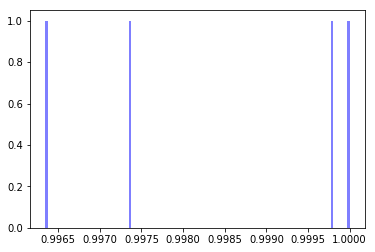

Meta Param: radius = 0.4, factor = 1.5, num iterations = 3.75, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9973746827905636, 0.9959593547014138, 0.98820470027216]
Average Fractional Reward: 0.9953846844410343
Histogram of Fractional Rewards:


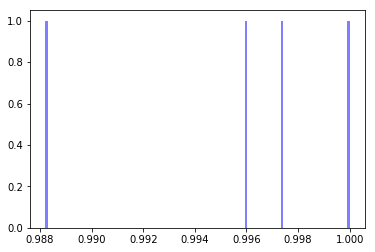

Meta Param: radius = 0.4, factor = 1.5, num iterations = 3.75, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9959828103138246, 0.9908684558330983, 0.9944915030984837]
Average Fractional Reward: 0.9953356923113517
Histogram of Fractional Rewards:


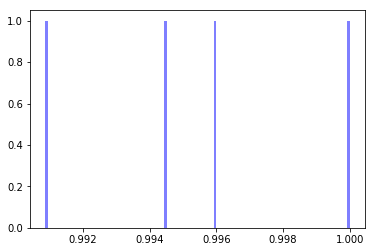

Meta Param: radius = 0.4, factor = 2, num iterations = 5.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9997799413507129, 0.9963447071697877, 0.9973621407028117]
Average Fractional Reward: 0.9983716973058281
Histogram of Fractional Rewards:


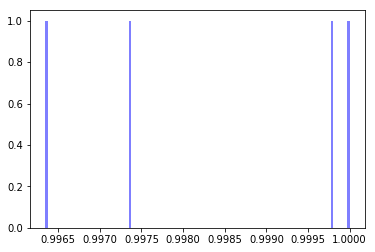

Meta Param: radius = 0.4, factor = 2, num iterations = 5.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9973746827905636, 0.9959593547014138, 0.98820470027216]
Average Fractional Reward: 0.9953846844410343
Histogram of Fractional Rewards:


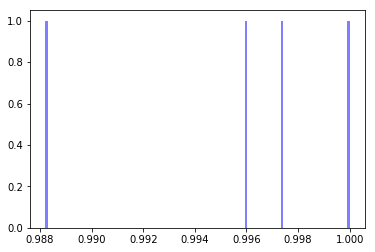

Meta Param: radius = 0.4, factor = 2, num iterations = 5.0, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9952408251521905, 0.9963537810265664, 0.9809525545748395]
Average Fractional Reward: 0.9931367901883992
Histogram of Fractional Rewards:


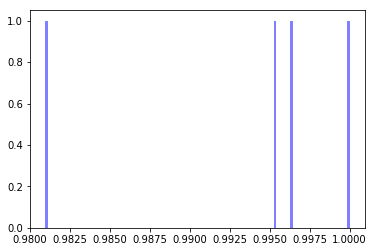

Meta Param: radius = 0.6, factor = 1, num iterations = 1.6666666666666667, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9973053024817554, 0.9964482147853575, 0.9904540035895252]
Average Fractional Reward: 0.9960518802141596
Histogram of Fractional Rewards:


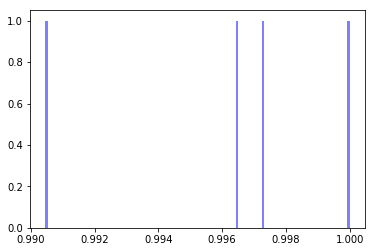

Meta Param: radius = 0.6, factor = 1, num iterations = 1.6666666666666667, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 1.0, 0.9889219603575882, 0.9064510946538649]
Average Fractional Reward: 0.9738432637528632
Histogram of Fractional Rewards:


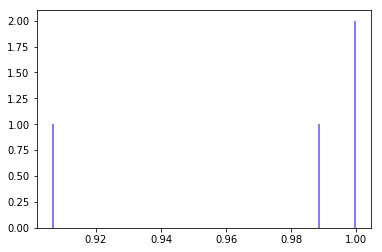

Meta Param: radius = 0.6, factor = 1, num iterations = 1.6666666666666667, initia uhat = full_open
List of Fractional Rewards: [0.9960818586838903, 0.9949882500964184, 0.939153183960502, 0.8641822635564453]
Average Fractional Reward: 0.9486013890743141
Histogram of Fractional Rewards:


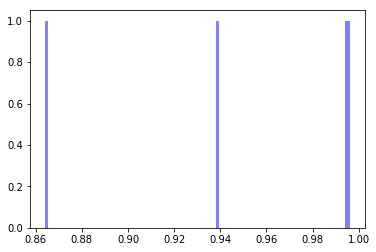

Meta Param: radius = 0.6, factor = 1.5, num iterations = 2.5, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9973053024817554, 0.9964482147853575, 0.9904540035895252]
Average Fractional Reward: 0.9960518802141596
Histogram of Fractional Rewards:


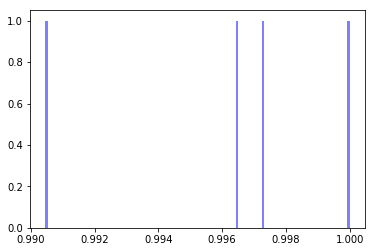

Meta Param: radius = 0.6, factor = 1.5, num iterations = 2.5, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 1.0, 0.9893623007969082, 0.9064510946538649]
Average Fractional Reward: 0.9739533488626932
Histogram of Fractional Rewards:


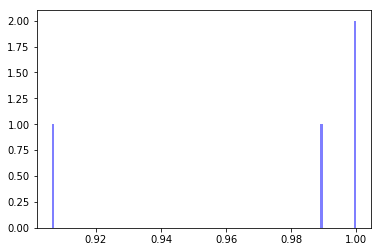

Meta Param: radius = 0.6, factor = 1.5, num iterations = 2.5, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9949882500964184, 0.9882901824887955, 0.8641822635564453]
Average Fractional Reward: 0.9618651740354149
Histogram of Fractional Rewards:


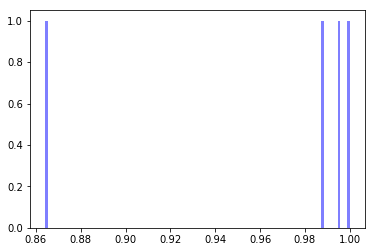

Meta Param: radius = 0.6, factor = 2, num iterations = 3.3333333333333335, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9960705991407793, 0.9964482147853575, 0.9904540035895252]
Average Fractional Reward: 0.9957432043789155
Histogram of Fractional Rewards:


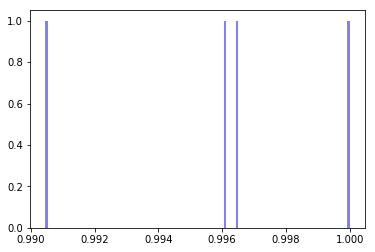

Meta Param: radius = 0.6, factor = 2, num iterations = 3.3333333333333335, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9974204955213505, 0.9893623007969082, 0.9064510946538638]
Average Fractional Reward: 0.9733084727430306
Histogram of Fractional Rewards:


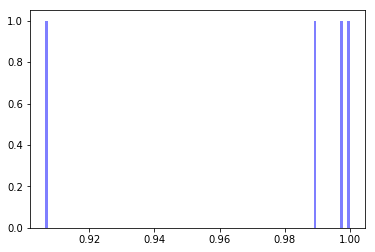

Meta Param: radius = 0.6, factor = 2, num iterations = 3.3333333333333335, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.99792294403659, 0.9960622117957577, 0.8641822635564453]
Average Fractional Reward: 0.9645418548471982
Histogram of Fractional Rewards:


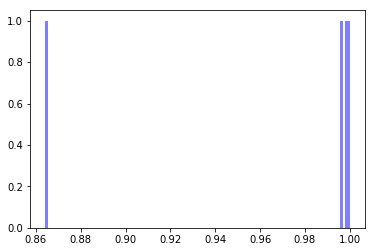

In [30]:
# Now for each combination of meta-parameters we can plot a histogram of the fractional rewards.
# This should give an idea of how good the meta-parameters are for all the instances.


# Here you can choose which combination of meta-param to plot
meta_parameters = {
        "trust_region_radius":[0,0.05,0.1,0.2,0.4,0.6],
        "max_inner_iterations_mult":[1, 1.5, 2],
        "initial_uhat":["dynamic_gradient", "full_lockdown", "full_open"]
    }


#You can choose which combination of parameters to plot
xis = [0, 30 * 37199.03]
# , 140 * 37199.03]
etas = [0,0.1]



for radius in meta_parameters["trust_region_radius"]:
    for factor in meta_parameters["max_inner_iterations_mult"]:
        for initial_uhat in meta_parameters["initial_uhat"]:
            print(f"Meta Param: radius = {radius}, factor = {factor}, num iterations = {factor/radius if radius>0 else 0}, initia uhat = {initial_uhat}")
            frac_rewards_list = list(all_data.loc[(all_data.radius==radius) &
                                                  (all_data.factor==factor) & 
                                                  (all_data.initial_uhat==initial_uhat) &
                                                  (all_data.xi.isin(xis)) &
                                                  (all_data.eta.isin(etas)), "FractionalReward"])
            print(f"List of Fractional Rewards: {frac_rewards_list}")
            print(f"Average Fractional Reward: {np.mean(frac_rewards_list)}")
            num_bins = 128
            print("Histogram of Fractional Rewards:")
            plt.hist(frac_rewards_list, num_bins, facecolor='blue', alpha=0.5)
            plt.show()